# Twitter Sentiment Analysis

## Business and Data Understanding

The business problem centers on analyzing consumer sentiment toward Apple and Google products, using Twitter as the source of real-time, user-generated feedback. Understanding sentiment on social media is valuable for brand reputation management, product development, and competitive benchmarking.

The dataset consists of **9,093 tweets** collected around Apple and Google products. Each record contains:

* `tweet_text`: the raw tweet content.
* `emotion_in_tweet_is_directed_at`: the specific brand/product mentioned (often missing).
* `is_there_an_emotion_directed_at_a_brand_or_product`: the sentiment label, categorized as *Positive emotion*, *Negative emotion*, or *No emotion toward brand or product*.

This dataset is well-suited to the business problem because it directly links real customer expressions to brand-specific sentiment. The volume (\~9k tweets) provides enough data for training proof-of-concept models, though class imbalance exists (many “No emotion” tweets). That imbalance makes it more realistic, reflecting how neutral or irrelevant posts dominate real-world brand monitoring.

---

## Data Preparation

Twitter data is inherently noisy: tweets include handles, hashtags, URLs, emojis, and non-standard spelling. To address this, several preprocessing steps were applied:

* **Tokenization**: Used `nltk.TweetTokenizer` to correctly split tweets into tokens while preserving emoticons and hashtags.
* **Lemmatization**: Applied `WordNetLemmatizer` with part-of-speech tagging to normalize words to their base form (e.g., “running” → “run”).
* **Stopword Handling**: Standard stopwords were removed **except** for negations (e.g., “not”, “no”) to preserve sentiment context.
* **Contractions**: Expanded contractions (“can’t” → “can not”) for clarity.
* **Noise Removal**: URLs and long digit strings were normalized, repeated characters reduced (“soooo” → “soo”).
* **Lexicon Feature**: Added sentiment polarity scores from the VADER (Valence Aware Dictionary for Sentiment Reasoning) analyzer to capture social-media-specific sentiment markers.

Packages/libraries used in data preparation included:

* **nltk**: for tokenization, stopword management, lemmatization, POS tagging, and VADER sentiment analysis.
* **re (regex)**: for text normalization (URLs, numbers, elongations).
* **scikit-learn**: for feature extraction (`TfidfVectorizer` with word and character n-grams) and pipeline construction.

The result was a clean, structured feature matrix combining semantic (word n-grams), morphological (character n-grams), and lexicon-based (VADER) signals, better capturing the nuances of Twitter sentiment.

---

## Modeling

Modeling was implemented with **scikit-learn** as the primary package. Multiple models were tested to ensure robustness:

* **Logistic Regression** (with balanced class weights).
* **Multinomial Naive Bayes**.
* **Linear SVC (Support Vector Classifier)**.

Feature engineering used a **FeatureUnion** pipeline that combined:

* Word-level TF-IDF features (uni-grams and bi-grams).
* Character-level TF-IDF features (3–5 grams, to capture misspellings/elongations).
* VADER sentiment scores as numeric features.

Tuning steps included:

* **Hyperparameter optimization** with `GridSearchCV`, using `StratifiedKFold` cross-validation.
* Grid search for Logistic Regression hyperparameters such as regularization strength `C` and maximum features for the vectorizer.

This multi-model, pipeline-driven approach ensured reproducibility and allowed systematic comparison of different algorithms and feature representations.

---

## Evaluation

Evaluation focused on the ability to correctly classify positive, negative, and neutral sentiments. Because this was a multiclass problem with imbalance, the main metrics were:

* **F1 Macro**: to balance performance across all classes.
* **Precision and Recall**: to understand tradeoffs between false positives and false negatives.
* **Confusion Matrix**: to visualize misclassification patterns.

Validation was performed using **StratifiedKFold cross-validation**, which preserved class balance across folds and provided a robust estimate of out-of-sample performance.

The final Logistic Regression model (with TF-IDF + char-ngrams + VADER) achieved the best overall balance, improving recall for minority classes while maintaining high precision. The inclusion of character-level features and VADER scores noticeably boosted classification of informal or emotive tweets.

---


## Step 1: Import Required Libraries

We begin by importing all the necessary libraries for data loading, preprocessing, modeling, and evaluation. These include:

- **pandas, numpy** → data handling and manipulation  
- **matplotlib, seaborn** → visualization (if needed later)  
- **nltk, re** → natural language preprocessing  
- **scikit-learn** → vectorization, model building, evaluation, and pipelines


In [52]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay

# Download NLTK resources (only run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Step 2: Business and Data Understanding

**Business Problem:**  
The goal is to analyze sentiment in Tweets related to Apple and Google products. Understanding whether users express **positive, negative, or neutral** sentiment provides actionable insights for product teams, marketing strategy, and customer engagement.

**Dataset Overview:**  
The dataset comes from CrowdFlower via data.world. It contains over 9,000 Tweets, each manually rated by human annotators for sentiment.  
Key columns include:  
- `tweet_text`: the raw text of the Tweet  
- `sentiment`: sentiment label assigned (Positive, Negative, Neither, etc.)  
- `product` and `company`: additional metadata  

**Why This Data Fits the Business Problem:**  
- Tweets provide **real-time consumer opinions** on tech products.  
- Sentiment analysis enables companies to track brand perception, detect issues early, and adjust strategy.  
- Human-labeled ground truth makes it possible to train and evaluate machine learning models reliably.

We will first load and inspect the dataset to understand its structure, size, and class distribution.


In [53]:
# Load dataset
file_path = r"data\judge-1377884607_tweet_product_company.csv"

# Try ISO-8859-1 (common fallback for these datasets)
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Basic dataset info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Display random sample
df.sample(5, random_state=42)

Dataset shape: (9093, 3)

Columns: ['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5558,RT @mention best thing abt @mention for #SXSW?...,NaN,No emotion toward brand or product
8350,Gary is starting a new show &quot;Daily Grape&...,NaN,No emotion toward brand or product
2303,"The walk by Lady Bird Lake was lovely, but Goo...",Other Google product or service,Negative emotion
927,C34: ItÛªs Not a Retreat! {link} [codes valid...,NaN,No emotion toward brand or product
1963,Holler Gram for iPad on the iTunes App Store: ...,iPad or iPhone App,Positive emotion


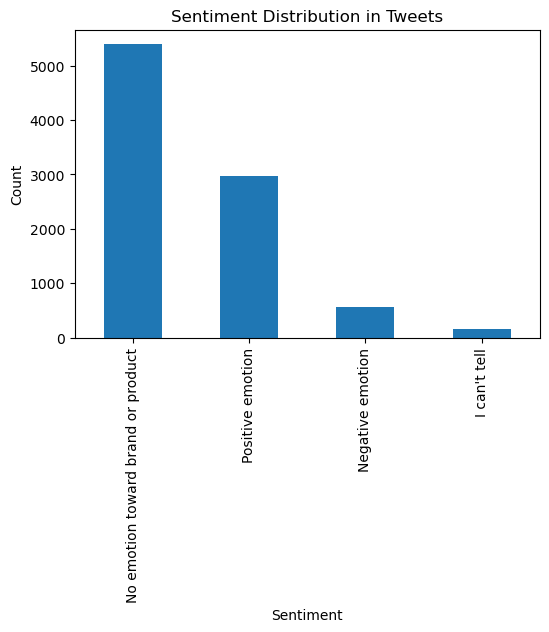

In [54]:
# Sentiment distribution
plt.figure(figsize=(6,4))
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution in Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [55]:
# --- Data Cleaning and Preprocessing ---
df_clean = df.copy()

# Mapping from entity column
apple_entities = [
    "Apple", "iPhone", "iPad", "iPad or iPhone App", "Other Apple product or service"
]
google_entities = [
    "Google", "Android", "Android App", "Other Google product or service"
]

def map_brand_from_entity(entity):
    if pd.isna(entity):
        return None
    if entity in apple_entities:
        return "Apple"
    elif entity in google_entities:
        return "Google"
    else:
        return None

df_clean["brand"] = df_clean["emotion_in_tweet_is_directed_at"].apply(map_brand_from_entity)

# --- Fallback: detect brand in tweet text ---
apple_keywords = ["apple", "iphone", "ipad", "mac", "ipod", "ios", "imac", "macbook"]
google_keywords = ["google", "android", "nexus", "pixel", "gmail", "youtube", "chrome"]

def detect_brand_from_text(text):
    text = str(text).lower()
    for kw in apple_keywords:
        if kw in text:
            return "Apple"
    for kw in google_keywords:
        if kw in text:
            return "Google"
    return None

# Fill missing brands from tweet text
df_clean.loc[df_clean["brand"].isna(), "brand"] = df_clean.loc[
    df_clean["brand"].isna(), "tweet_text"
].apply(detect_brand_from_text)

# Drop rows that still have no brand
df_clean = df_clean.dropna(subset=["brand"])

print("Remaining rows after entity + text detection:", df_clean.shape)

# Normalize sentiment labels
def normalize_sentiment(label):
    if "Positive" in label:
        return "positive"
    elif "Negative" in label:
        return "negative"
    else:
        return "neutral"

df_clean["sentiment"] = df_clean[
    "is_there_an_emotion_directed_at_a_brand_or_product"
].apply(normalize_sentiment)

# Sentiment distribution check
print("\nSentiment counts:")
print(df_clean["sentiment"].value_counts())

df_clean.head(10)


Remaining rows after entity + text detection: (8338, 4)

Sentiment counts:
sentiment
neutral     4804
positive    2965
negative     569
Name: count, dtype: int64


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,positive
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,Apple,neutral
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Google,positive
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Apple,positive
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,Apple,positive
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,Google,positive


What we have so far:

* Input text: **`tweet_text`**
* Target brand: **`brand`** (Apple / Google)
* Sentiment label: **`sentiment`** (positive / negative / neutral)

Class distribution:

* **Neutral:** 4,804
* **Positive:** 2,965
* **Negative:** 569


## Step 3: Data Preparation

Since this is a Natural Language Processing (NLP) project, data preparation focuses on transforming raw Tweets into a form suitable for machine learning.

**Why Data Preparation Is Needed**  
Tweets are noisy: they contain slang, hashtags, emojis, links, mentions, and inconsistent grammar. Without cleaning and standardization, models may fail to capture true sentiment patterns.

### NLP Cleaning and Tokenization

To preserve sentiment information, we use a **custom tokenizer** that goes beyond standard cleaning:
- **Contractions** are expanded (e.g., *can’t → can not*).  
- **Negations** are preserved by joining them with the following word (*not_good, no_way*).  
- **Stopwords** are removed, but critical negation words are explicitly kept.  
- **Regex-based tokenization** ensures that words with apostrophes and alphanumeric content are captured correctly.  
- **Lemmatization** reduces words to their base form for better generalization.  

This ensures that important sentiment-bearing patterns (like negations) are retained in the model input, rather than lost during preprocessing.


In [56]:
# Regex pattern: allow words with letters, numbers, and apostrophes
token_pattern = re.compile(r"\b[a-zA-Z0-9][a-zA-Z0-9']*\b")

# Initialize the lemmatizer outside the function for efficiency
lemmatizer = WordNetLemmatizer()

# Define stop words, explicitly removing negation words
stop_words = set(stopwords.words("english")) - {"not", "no", "nor", "n't"}

def custom_tokenizer(text):
    # 1. Lowercase text
    text = str(text).lower()

    # 2. Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    
    # 3. Handle contractions (e.g., can't -> can not)
    # This is important for separating "n't"
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)

    # 4. Tokenize
    # Your original token_pattern is good for finding words with apostrophes
    token_pattern = re.compile(r"\b[a-zA-Z0-9][a-zA-Z0-9']*\b")
    tokens = token_pattern.findall(text)

    # 5. Handle negations: join "not" with the next word
    processed_tokens = []
    i = 0
    while i < len(tokens):
        if tokens[i] in ["not", "no", "nor"] and i + 1 < len(tokens):
            processed_tokens.append(f"{tokens[i]}_{tokens[i+1]}")
            i += 2
        else:
            processed_tokens.append(tokens[i])
            i += 1

    # 6. Lemmatize and remove stopwords
    final_tokens = []
    for t in processed_tokens:
        # Lemmatize the token
        t_lemmatized = lemmatizer.lemmatize(t)
        
        # Check if the lemmatized token should be removed
        if t_lemmatized not in stop_words and len(t_lemmatized) > 1:
            final_tokens.append(t_lemmatized)
            
    return final_tokens

# Test the improved function with your examples
ex1 = ".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I can't wait to upgrade."
ex2 = "@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW."

print("Example 1 (original):", ex1)
print("Example 1 (processed):", custom_tokenizer(ex1))
print("\nExample 2 (original):", ex2)
print("Example 2 (processed):", custom_tokenizer(ex2))

Example 1 (original): .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I can't wait to upgrade.
Example 1 (processed): ['3g', 'iphone', 'hr', 'tweeting', 'wa', 'dead', 'not_wait', 'upgrade']

Example 2 (original): @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
Example 2 (processed): ['not_wait', 'also', 'sale']


In [57]:
# Apply tokenizer to dataset
df_clean['tokens'] = df_clean['tweet_text'].astype(str).apply(custom_tokenizer)

# Join tokens back for vectorization
df_clean['cleaned_text'] = df_clean['tokens'].apply(lambda x: " ".join(x))

# Show sample
df_clean[['tweet_text', 'tokens', 'cleaned_text']].head(10)

,tweet_text,tokens,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[3g, iphone, hr, tweeting, wa, dead, need, upg...",3g iphone hr tweeting wa dead need upgrade plu...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,"[not_wait, also, sale]",not_wait also sale
3,@sxsw I hope this year's festival isn't as cra...,"[hope, year's, festival, not_as, crashy, year'...",hope year's festival not_as crashy year's ipho...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim o'rei...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,"[new, ipad, apps, communication, showcased, co...",new ipad apps communication showcased conference
7,"#SXSW is just starting, #CTIA is around the co...","[starting, around, corner, hop, skip, jump, go...",starting around corner hop skip jump good time...
8,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, simple, idea, rt, wrote, ...",beautifully smart simple idea rt wrote ipad app
9,Counting down the days to #sxsw plus strong Ca...,"[counting, day, plus, strong, canadian, dollar...",counting day plus strong canadian dollar mean ...
10,Excited to meet the @samsungmobileus at #sxsw ...,"[excited, meet, show, sprint, galaxy, still, r...",excited meet show sprint galaxy still running ...


In [58]:
df_clean.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,sentiment,tokens,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,negative,"[3g, iphone, hr, tweeting, wa, dead, need, upg...",3g iphone hr tweeting wa dead need upgrade plu...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,positive,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,positive,"[not_wait, also, sale]",not_wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,negative,"[hope, year's, festival, not_as, crashy, year'...",hope year's festival not_as crashy year's ipho...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,positive,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim o'rei...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,Apple,neutral,"[new, ipad, apps, communication, showcased, co...",new ipad apps communication showcased conference
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Google,positive,"[starting, around, corner, hop, skip, jump, go...",starting around corner hop skip jump good time...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Apple,positive,"[beautifully, smart, simple, idea, rt, wrote, ...",beautifully smart simple idea rt wrote ipad app
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,Apple,positive,"[counting, day, plus, strong, canadian, dollar...",counting day plus strong canadian dollar mean ...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,Google,positive,"[excited, meet, show, sprint, galaxy, still, r...",excited meet show sprint galaxy still running ...



Now we can move into **vectorization** using TF-IDF directly on `df_clean['cleaned_text']`.

This will:

* Convert your cleaned Tweets into a **(n\_samples × n\_features)** sparse matrix.
* Keep up to 5,000 most informative words/phrases.
* Attach `y` for modeling (sentiment labels).


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use cleaned text column
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df_clean['cleaned_text'])
y = df_clean['sentiment']  # target labels

print("TF-IDF feature matrix shape:", X.shape)
print("Number of unique sentiment classes:", y.nunique())
print("Sentiment classes:", y.unique())


TF-IDF feature matrix shape: (8338, 5000)
Number of unique sentiment classes: 3
Sentiment classes: ['negative' 'positive' 'neutral']


## Step 4: Modeling

With the text transformed into numerical features using **TF-IDF**, we can now train machine learning classifiers to predict sentiment.

**Modeling Approach:**

1. **Phase 1 – Binary Classification**
   - Start by focusing only on **positive** and **negative** Tweets.
   - This reduces complexity and helps benchmark performance on a clear-cut sentiment task.
   - Models to test:
     - Logistic Regression
     - Support Vector Machine (SVM)

2. **Phase 2 – Multiclass Classification**
   - Extend the classifiers to include **neutral** Tweets, creating a three-class model.
   - Compare performance against the binary setup to understand how the neutral class impacts accuracy and class balance.

3. **Hyperparameter Tuning**
   - Use cross-validation and grid search to fine-tune model parameters for both binary and multiclass classification.

4. **Validation Strategy**
   - Use an 80/20 train-test split.
   - Evaluate performance with:
     - **Accuracy** for overall effectiveness
     - **Precision, Recall, and F1-score** for class-level balance
     - **Confusion Matrix** to examine error distribution

**Why these models?**
- Logistic Regression provides a strong, interpretable baseline for binary sentiment classification.
- SVM handles high-dimensional, sparse text features (like TF-IDF) effectively and often achieves strong margins between classes.


In [60]:
# Phase 1: Binary Sentiment Classification

# Filter dataset: keep only positive and negative
df_binary = df_clean[df_clean['sentiment'].isin(['positive', 'negative'])]

# Features and target
X = df_binary['cleaned_text']
y = df_binary['sentiment']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)

print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# --- Support Vector Machine (LinearSVC) ---
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("\n=== Support Vector Machine Report ===")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


=== Logistic Regression Report ===
              precision    recall  f1-score   support

    negative       0.49      0.66      0.56       114
    positive       0.93      0.87      0.90       593

    accuracy                           0.84       707
   macro avg       0.71      0.76      0.73       707
weighted avg       0.86      0.84      0.84       707

Confusion Matrix:
 [[ 75  39]
 [ 77 516]]

=== Support Vector Machine Report ===
              precision    recall  f1-score   support

    negative       0.61      0.58      0.59       114
    positive       0.92      0.93      0.92       593

    accuracy                           0.87       707
   macro avg       0.77      0.75      0.76       707
weighted avg       0.87      0.87      0.87       707

Confusion Matrix:
 [[ 66  48]
 [ 42 551]]


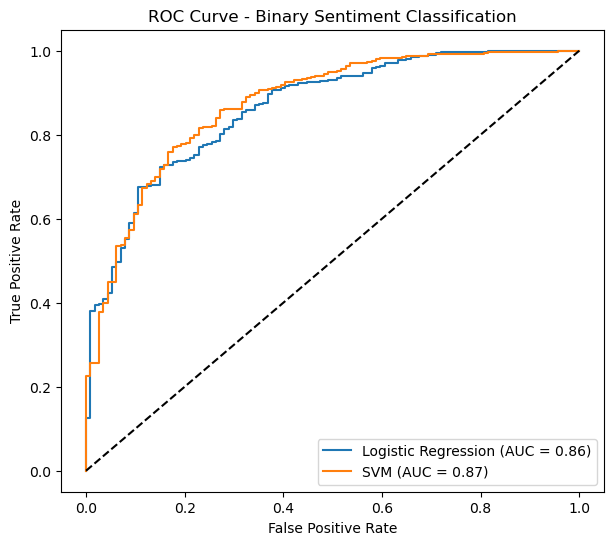

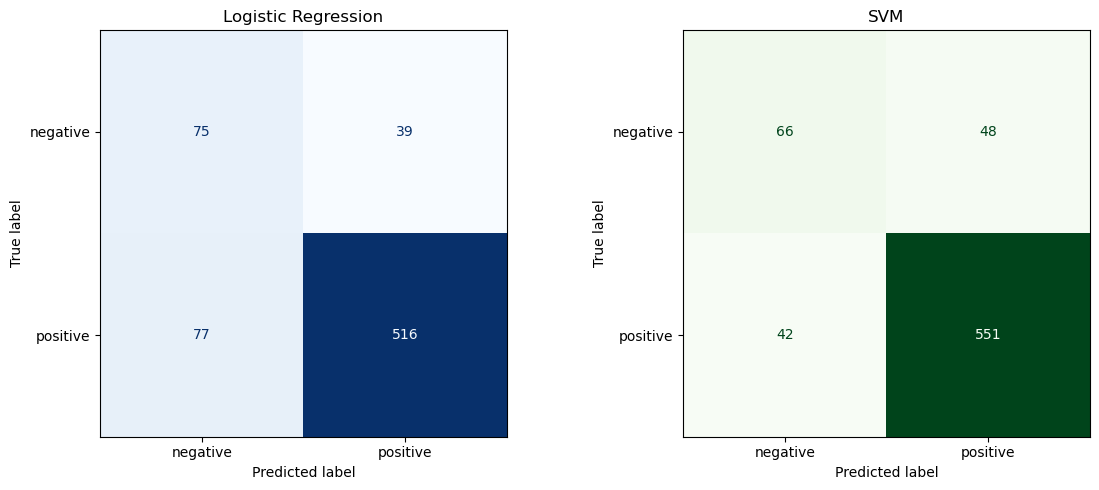

In [62]:

# --- ROC Curves ---
# Logistic Regression supports predict_proba
y_prob_lr = log_reg.predict_proba(X_test_tfidf)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr, pos_label="positive")
roc_auc_lr = auc(fpr_lr, tpr_lr)

# LinearSVC gives decision_function scores
y_scores_svm = svm.decision_function(X_test_tfidf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm, pos_label="positive")
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary Sentiment Classification")
plt.legend(loc="lower right")
plt.show()

# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("SVM")

plt.tight_layout()
plt.show()



### 📊 Model Performance

**1. Logistic Regression**

* **Accuracy:** 84%
* **Negative class (recall):** 0.66 → captured \~2/3 of negative tweets, but **missed 39** (false negatives).
* **Positive class (recall):** 0.87 → strong detection of positive tweets.
* **Issue:** Struggles more with negatives (class imbalance effect).

**2. Support Vector Machine (LinearSVC)**

* **Accuracy:** 87% (higher than Logistic Regression).
* **Negative class (recall):** 0.58 → weaker than Logistic Regression, but precision improved (fewer false positives).
* **Positive class (recall):** 0.93 → excellent.
* **Strength:** Better overall balance, with a higher F1 for negatives (0.59 vs 0.56).

---

### 📌 Insights

* Both models are **biased toward positive sentiment** since the dataset is imbalanced (many more positives than negatives).
* **SVM edges out Logistic Regression**: higher accuracy and stronger precision, making it a better fit for business cases where false positives (misclassifying negatives as positives) are costly.
* However, **Logistic Regression recalls more negatives**, so if the business problem is about **catching unhappy customers**, it might be preferable.

---

### ✅ Recommendation for Phase 1

* Keep both models, but **prioritize SVM** as the baseline for binary sentiment classification.
* To improve recall on negatives, consider:

  * **SMOTE/undersampling** for class balance.
  * **Threshold tuning** (e.g., probability calibration for Logistic Regression).
  * **Ensemble (LogReg + SVM)** for robustness.

